# Self Driving Car Engineer Nanodegree
## Project: Advanced Lane Finding

In this project we use the tools learned in the previous lessons to find lane lines in any conditions as well as handling curved lanes, and finding the curvature radius of the road.

We will process each image using the following roadmap:
1. Calibrate the Camera
2. undistort image
    a. capture image in outfile
3. get a binary image using thresholding
    a. capture image in outfile
4. Perspective transform
    a. capture image in outfile
5. find lane pixel
    a. capture image in outfile
6. get curvature (in meters)
7. load all of this back onto the original image/video

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import glob
from datetime import datetime
%matplotlib inline
%matplotlib qt

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Camera Calibration
Using the folder of images 'camera_cal', we will use these to generate the object points and image points for the camera.
Finally, using the arrays, we will perform the calibrateCamera to get the calibration matrix and distortion coefficients.

In [3]:
def cam_cal(x, y):
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)
    # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    #perform camera calibation on the last image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist

In [4]:
# calibrate the camera
ret, mtx, dist = cam_cal(9, 6)

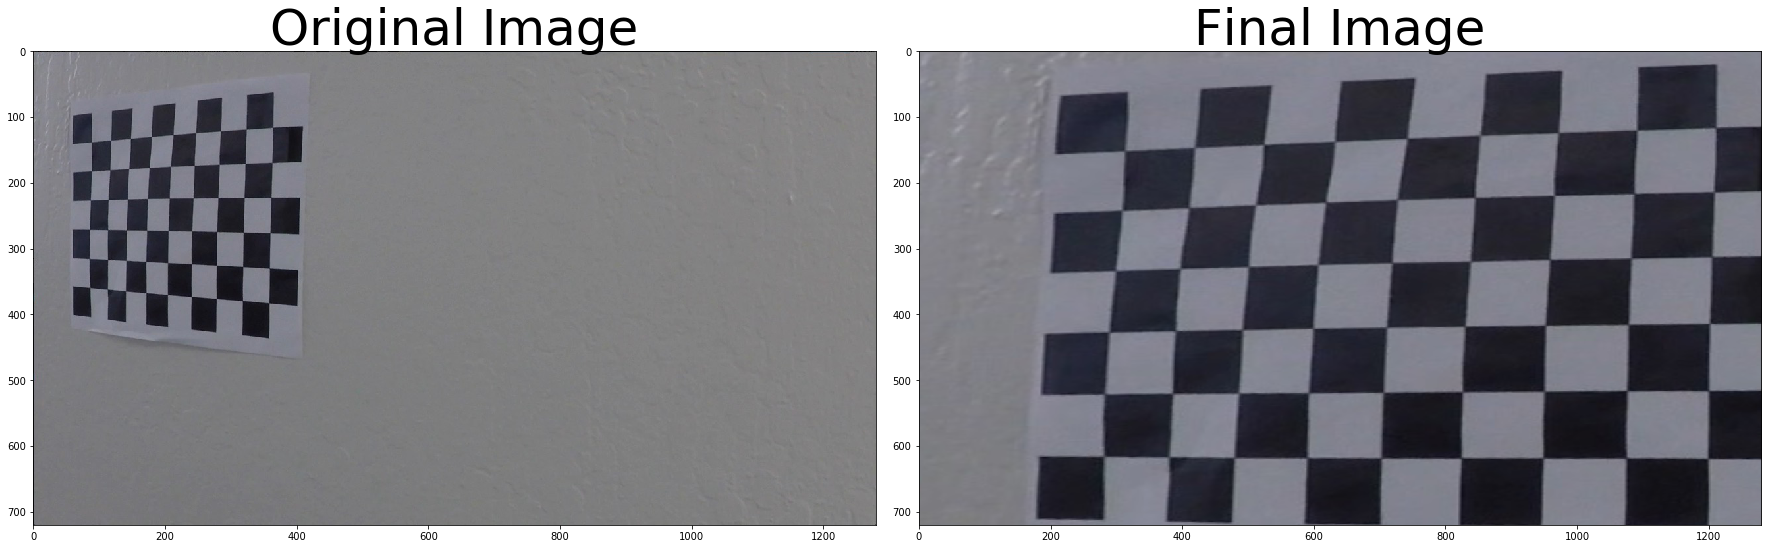

In [5]:
### Test Camera Calibration
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    img_size = (img.shape[1], img.shape[0])
    # 4) If corners found: 
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
         #Note: you could pick any four of the detected corners 
         # as long as those four corners define a rectangle
         #One especially smart way to do this would be to use four well-chosen
         # corners that were automatically detected during the undistortion steps
         #We recommend using the automatic detection of corners in your code
        src = np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        offset = 100 # offset for dst points
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    #delete the next two lines
#    M = None
#    warped = np.copy(img) 
    return warped

image = mpimg.imread('camera_cal/calibration19.jpg')
top_down = corners_unwarp(image, 9, 6, mtx, dist)
new_path = "output_images/" + "Cam_Cal-Orig" + ".jpg"
plt.imsave(new_path, image)
new_path = "output_images/" + "Cam_Cal-Warp" + ".jpg"
plt.imsave(new_path, top_down)

#plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Final Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Get Binary Image
Using thresholding, find the lane lines under any lighting condition or road condition.  Using a combination of the following methods, return a black and white image that focuses on the lane lines, and eliminates as much noise as possible.

In [6]:
###  different threshold methods
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif (orient == 'y'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_select(img, channel = 's', thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 's':
        C = hls[:,:,2]
    elif channel == 'h':
        C = hls[:,:,0]
    elif channel == 'l':
        C = hls[:,:,1]
    # 2) Apply a threshold to the selected channel channel
    binary_output = np.zeros_like(C)
    binary_output[(C > thresh[0]) & (C <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


In [7]:
def binary_image(image, orient, channel, dir, mag, sobel_kernel, thresh, dir_thresh, chan_thresh, mag_thresh):
    # thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x' or orient == 'y':
        sobel_binary = abs_sobel_thresh(image, orient, sobel_kernel, thresh)
    else:
        sobel_binary = np.zeros_like(gray)
    if channel == 's' or channel == 'h' or channel == 'l':
        c_binary = hls_select(image, channel, chan_thresh)
    else:
        c_binary = np.zeros_like(gray)
    if dir == 'x':
        dir_binary = dir_threshold(image, sobel_kernel, dir_thresh)
    else:
        dir_binary = np.zeros_like(gray)
    if mag == 'x':
        mag_binary = mag_threshold(image, sobel_kernel, mag_thresh)
    else:
        mag_binary = np.zeros_like(gray)
    
    # Combine the two binary thresholds
#    plt.imshow(sobel_binary, cmap='gray')
#    plt.imshow(c_binary, cmap='gray')
##    plt.imshow(dir_binary, cmap='gray')
#    plt.imshow(mag_binary, cmap='gray')
    
    combined_binary = np.zeros_like(gray)
    combined_binary[(mag_binary == 1) | (dir_binary == 1) | (c_binary == 1) | (sobel_binary == 1)] = 1

    return combined_binary

# Get Binary Warped Image
Use the binary image to convert the perspective to see the lane lines from up above.

In [8]:
def warp_image(image, mtx, dist, t_h, t_w1, t_w3):
    # defining a trapezoid of the lane lines to be the source points
    img_size = (image.shape[1], image.shape[0])
    t_w4 = 1 - t_w3
    t_w2 = 1 - t_w1
    src = np.float32([[(int(img_size[0]*t_w1), int(img_size[1]*t_h)),
                       (int(img_size[0]*t_w2), int(img_size[1]*t_h)),
                       (int(img_size[0]*t_w3), int(img_size[1])),
                       (int(img_size[0]*t_w4), int(img_size[1]))]], dtype=np.int32)
    # defining destination points
    offset = 0 # offset for dst points
    dst = np.float32([[offset, offset], 
                    [img_size[0]-offset, offset], 
                    [img_size[0]-offset, img_size[1]-offset], 
                    [offset, img_size[1]-offset]])

    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, Minv

# Get Initial Polynomial Equation
Using the multiple window approach, create a binomial equation to for the best fit of the line.

In [9]:
def find_lane_pixels(binary_warped, nwindows, margin, minpix):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, 
                                                                 righty, [0, 0, 0], [0, 0, 0])

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#    plt.plot(left_fitx, ploty, color='yellow')
#    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##

    return left_fitx, right_fitx, ploty, rightx, leftx, righty, lefty, out_img, left_fit, right_fit


In [17]:
def search_around_poly(binary_warped, margin, left_fit, right_fit):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, 
                                                                 rightx, righty, left_fit, right_fit)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#    plt.plot(left_fitx, ploty, color='yellow')
#    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, ploty, rightx, leftx, righty, lefty, result, left_fit, right_fit

In [11]:
def fit_poly(img_shape, leftx, lefty, rightx, righty, lf_old, rf_old):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # if the slope of the first cooefficient reverses from the past fit, ignore the current
#    if (left_fit[0] > 0 and lf_old[0] < 0) or (left_fit[0] < 0 and lf_old[0] > 0):
#        left_fit = lf_old
#    if (right_fit[0] > 0 and rf_old[0] < 0) or (right_fit[0] < 0 and rf_old[0] > 0):
#        right_fit = rf_old
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

In [12]:
def fit_polynomial(binary_warped, undist, nwindows, margin, minpix, Minv, left_fit, right_fit):
    if left_fit[0] == 0 and left_fit[1] == 0 and left_fit[2] == 0:
        # Find our lane pixels first
        left_fitx, right_fitx, ploty, rightx, leftx, righty, lefty, out_img, left_fit, right_fit = find_lane_pixels(binary_warped, nwindows, margin, minpix)
    else:
        # use previous polyfit to find new windows
        left_fitx, right_fitx, ploty, rightx, leftx, righty, lefty, out_img, left_fit, right_fit = search_around_poly(binary_warped, margin, left_fit, right_fit)
        
    # Fit new polynomials to x,y in world space
    # Define conversions in x and y from pixels space to meters
    # take the difference between the first set of right and left lane points.
    if (rightx[0]-leftx[0] != 0):
        xm_per_pix = 3.7 / (rightx[0] - leftx[0])
    else:
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ym_per_pix = 30/720 # meters per pixel in y dimension
    if (rightx[0] < binary_warped.shape[1]):
        dist = (((rightx[0] - leftx[0])/2) + leftx[0] - (binary_warped.shape[1] / 2) ) * xm_per_pix
    else:
    # right line is off the page
        r_new = (right_fix[0] * binary_warped.shape[0])**2 * (right_fix[1]*binary_warped.shape[0]) + right_fix[2]
        print (r_new)
        dist = (((r_new - leftx[0])/2) + leftx[0] - (binary_warped.shape[1] / 2) ) * xm_per_pix

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result, out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, ploty, ym_per_pix, xm_per_pix, dist


# Get Radius of Curvature


In [13]:
def measure_curvature_real(left_fit_cr, right_fit_cr, ploty, ym_per_pix, xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Line Class
Used to keep track of certain variables throughout the life of the call.  Only applies for the video.


In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        self.frames = 0
        # x values of the last n fits of the line
#        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
#        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0, 0, 0]
        self.n = 10
        # Polynomial Values - keep the latest n
        self.poly_co_1 = [] 
        self.poly_co_2 = [] 
        self.poly_co_3 = [] 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
    def new_poly (self, poly):
        self.poly_co_1.append(poly[0])
        self.poly_co_2.append(poly[1])
        self.poly_co_3.append(poly[2])
        if len(self.poly_co_1) > self.n:
            np.delete(self.poly_co_1,0 )
        if len(self.poly_co_2) > self.n:
            np.delete(self.poly_co_2,0 )
        if len(self.poly_co_3) > self.n:
            np.delete(self.poly_co_3,0 )
        self.best_fit[0] = np.mean(self.poly_co_1)
        self.best_fit[1] = np.mean(self.poly_co_2)
        self.best_fit[2] = np.mean(self.poly_co_3)
        

# Process the Image


In [15]:
def process_image(image):
    # Set input values
    left_fit = np.array([0, 0, 0])
    right_fit = np.array([0, 0, 0])

    # set Trapezoid percentages based on the image dimension
    t_h = 0.65   # percentage of x value for height upper points
    t_w1 = 0.41  # percentage of y value for upper left point
    t_w3 = 1.0   # percentage of x value for lower left point
    ### set values for binary thresholding
    sobel_kernel = 9           # this is the kernel for the sobel thresholding

    orient = 'x'               # set to x, y, or blank if not used
    thresh = (20, 100)         # set this range for the sobel threshold

    channel = 's'              # set this to s, h, l, or blank if not used
    chan_thresh = (125, 230)     # set this range for the HLS channel threshold

    dir = ''                  # if directional thresholding should be used
    dir_thresh = (0, np.pi/4)  # set the range for directional thresholding.  leave blank if not used

    mag = 'x'                  # if magnitude thresholding should be used
    mag_thresh = (75, 125)      # set this range for the magnitude threshold

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 50

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    textpos1               = (15,75)
    textpos2               = (15,150)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    # first we undistort the image using the calibration matrix and distortion coefficients.
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Generate a binary image utilizing multiple functions to get the optimal lane lines in the image
    binary = binary_image(image, orient, channel, dir, mag, sobel_kernel, thresh, dir_thresh, chan_thresh, mag_thresh)
    # warp the image to see the binary image in a "top-down" view
    warped, Minv = warp_image(binary, mtx, dist, t_h, t_w1, t_w3)
    # Create the polynomial equation that best fits the lines
    result, out_img, left_fit, right_fit, left_fit_cr, right_fit_cr, ploty, ym_per_pix, xm_per_pix, dist_center = fit_polynomial(warped, 
        undist, nwindows, margin, minpix, Minv, Left.best_fit, Right.best_fit)

    left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr, ploty, ym_per_pix, xm_per_pix)
    # get average radius of curvature to display on image
    curverad = (left_curverad + right_curverad) / 2
    # get distance from the center of the lane (left of center vs. Right of Center)
    # calculate the lane width, assume car is centered in the picture.  
    
    text1 = 'Radius of Curvature: ' + str(int(curverad)) + "(m)"
    text2 = 'Vehicle is ' + str(round(dist_center,3)) + "m left of center"    

    cv2.putText(result, text1, textpos1, font, fontScale, fontColor, lineType)    
    cv2.putText(result, text2, textpos2, font, fontScale, fontColor, lineType)    

    if (right_fit[0] == 0 and right_fit[1] == 0 and right_fit[2] == 0):
        Right.detected = False
    else:
        Right.detected = True
        Right.current_fit = right_fit
        Right.radius_of_curvature = right_curverad
        Right.line_base_pos = dist_center
        Right.new_poly(right_fit)
    Right.frames += 1
    # after every so many frames, reset the polynomial coefficients and pull from the pixels
    if Right.frames % 20 == 0:
        Right.best_fit = [0, 0, 0]
        Right.poly_co_1 = []
        Right.poly_co_2 = []
        Right.poly_co_3 = []
        
    if (left_fit[0] == 0 and left_fit[1] == 0 and left_fit[2] == 0):
        Left.detected = False
    else:
        Left.detected = True
        Left.current_fit = left_fit
        Left.radius_of_curvature = left_curverad
        Left.line_base_pos = dist_center
        Left.new_poly(left_fit)
    Left.frames += 1    
    # after every so many frames, reset the polynomial coefficients and pull from the pixels
    if Left.frames % 20 == 0:
        Left.best_fit = [0,0,0]
        Left.poly_co_1 = []
        Left.poly_co_2 = []
        Left.poly_co_3 = []
    
#    if Right.detected == False or Left.detected == False:
#    new_path = "output_images/" + str(datetime.now(tz=None)) + "-orig" + ".jpg"
#    plt.imsave(new_path, image)
#    new_path = "output_images/" + str(datetime.now(tz=None)) + "-undist" + ".jpg"
#    plt.imsave(new_path, undist)
#    new_path = "output_images/" + str(datetime.now(tz=None)) + "-binary" + ".jpg"
#    plt.imsave(new_path, binary, cmap='gray')
#    new_path = "output_images/" + str(datetime.now(tz=None)) + "-warped" + ".jpg"
#    plt.imsave(new_path, warped, cmap='gray')
#    new_path = "output_images/" + str(datetime.now(tz=None)) + "-poly" + ".jpg"
#    plt.imsave(new_path, out_img, cmap='gray')
#    new_path = "output_images/" + str(datetime.now(tz=None)) + "-result" + ".jpg"
#    plt.imsave(new_path, result)

    return result

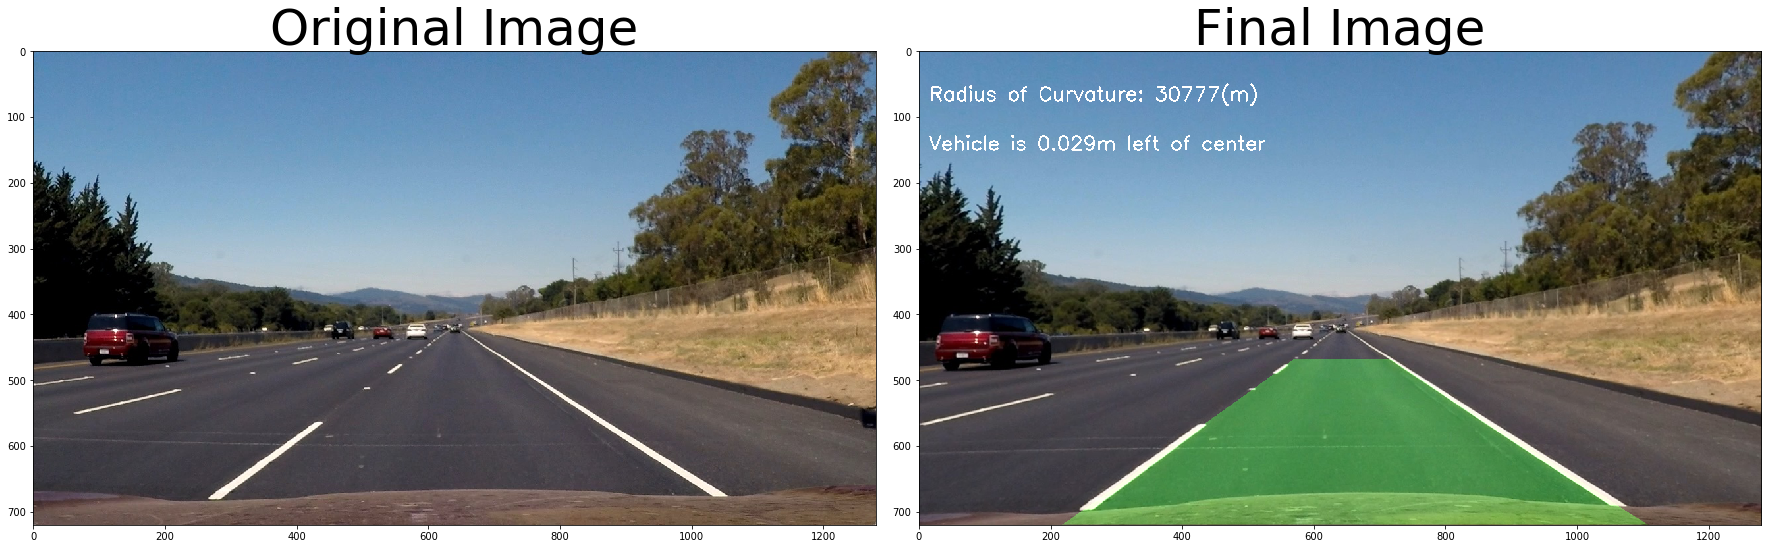

In [16]:
Left = Line()
Right = Line()
#reading in an image
image = mpimg.imread('test_images/straight_lines2.jpg')
#image = mpimg.imread('test_images/test3.jpg')
#image = mpimg.imread('test_images/MDP-04.jpg')
#img, left_fit, right_fit = process_image(image)
img = process_image(image)

#plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img, cmap='gray')
ax2.set_title('Final Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
Left = Line()
Right = Line()
first_output = 'video_output/project_video.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# To do so add .subclip(start_second,end_second) to the end of the line below
# Where start_second and end_second are integer values representing the start and end of the subclip
# You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
first_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time first_clip.write_videofile(first_output, audio=False)

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4


100%|█████████▉| 1260/1261 [05:05<00:00,  4.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 

CPU times: user 2min 22s, sys: 40.2 s, total: 3min 2s
Wall time: 5min 8s


In [19]:
first_output = 'video_output/project_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(first_output))

In [22]:
Left = Line()
Right = Line()
chall1_output = 'video_output/challenge_video.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# To do so add .subclip(start_second,end_second) to the end of the line below
# Where start_second and end_second are integer values representing the start and end of the subclip
# You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
second_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time second_clip.write_videofile(chall1_output, audio=False)

[MoviePy] >>>> Building video video_output/challenge_video.mp4
[MoviePy] Writing video video_output/challenge_video.mp4


100%|██████████| 485/485 [01:53<00:00,  4.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/challenge_video.mp4 

CPU times: user 52.4 s, sys: 17.2 s, total: 1min 9s
Wall time: 1min 55s


In [23]:
chall1_output =  'video_output/challenge_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chall1_output))

In [26]:
Left = Line()
Right = Line()
chall2_output = 'video_output/harder_challenge_video.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# To do so add .subclip(start_second,end_second) to the end of the line below
# Where start_second and end_second are integer values representing the start and end of the subclip
# You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
third_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time third_clip.write_videofile(chall2_output, audio=False)

[MoviePy] >>>> Building video video_output/harder_challenge_video.mp4
[MoviePy] Writing video video_output/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [05:36<00:00,  3.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/harder_challenge_video.mp4 

CPU times: user 2min 26s, sys: 38.2 s, total: 3min 4s
Wall time: 5min 40s


In [27]:
chall2_output =  'video_output/harder_challenge_video.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chall2_output))